In [1]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import sem

from cpsplines.mosek_functions.interval_constraints import IntConstraints
from cpsplines.psplines.bspline_basis import BsplineBasis
from cpsplines.psplines.penalty_matrix import PenaltyMatrix
from cpsplines.fittings.fit_cpsplines import CPsplines
from cpsplines.utils.gcv import GCV
import statsmodels.genmod.families.family
import mosek.fusion as mf

from Functions import poly

from Functions import simpleGCV
from Functions import choose_lambda
from Functions import simpson_spline_full
from Functions import simpson_spline_matrices
from Functions import intGCV
from Functions import choose_lambda_int
from Functions import create_obj_mat
from Functions import unconstrained_sof_fit
from Functions import cp_sof_fit
import time
from scipy.stats import norm

In [2]:
#ESTO PARA NUESTRO PROBLEMA
rankX = 20
alpha = 0.15
#Trabajaremos con estos datos
m = 50
T = np.linspace(0, 1, num=m)
Phi = np.append(np.tile(1/np.sqrt(m), (m, 1)), poly(T, degree=rankX-1)[0], axis = 1)
lambda1_ = np.arange(rankX, 0, -1)


T2 = np.linspace(0, 1, num=501)
betaT = norm.pdf(T, loc=1/2, scale=0.1)
betaT2  = norm.pdf(T2, loc=1/2, scale=0.1)


# betaT = beta(T)
#weights. 1/3 for the limits, 2/3 for the odd subintervals, 4/3 for the even ones. 

w = [1/3] + [4/3 if i%2==0 else 2/3 for i in range(2,501)] + [1/3]
W = 1/501* np.diag(w)


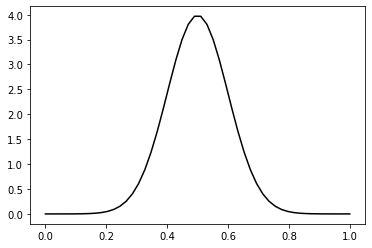

In [3]:
plt.plot(T,betaT, 'k-')

In [10]:
i=1
N=35
ssss="_".join(['X_normnn001', str(i+1), str(N)])
tttt="_".join(['y_normnn001', str(i+1), str(N)])
ssss

'X_normnn001_2_35'

In [ ]:
betaT=pd.read_csv("betaT_norm1.csv", header=None )
betaT=np.array(betaT).squeeze()
betaT2=pd.read_csv("betaT2_norm1.csv", header=None )
betaT2=np.array(betaT2).squeeze()

In [4]:
#Trabajaremos con estos datos
N=200
normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
eps = np.random.normal(0, 0.01, N)
Xi=[]
for j in range(rankX):
    z=normalfunc(lambda1_[j])
    Xi.append(z-z.mean())
X = np.dot(np.transpose(Xi), np.transpose(Phi))
lfterm = np.dot((1/m)*X, betaT)

y = alpha + lfterm + eps


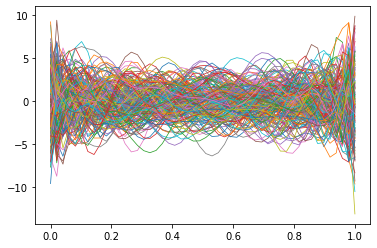

In [5]:
# He simplidicado las X

#Gráfico de las X
# Plot all rows of X against T
for i in range(X.shape[0]):
    plt.plot(T, X[i,:], linewidth=0.75)

## ERROR SIGUE UNA $N(0, 0.01)$

### Gráficos

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


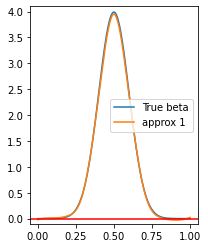

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


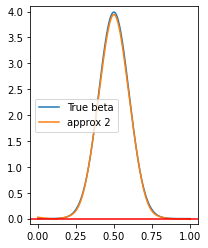

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


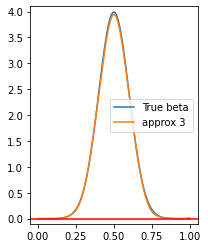

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


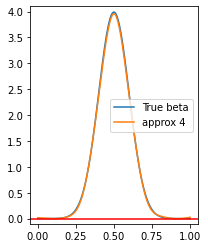

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


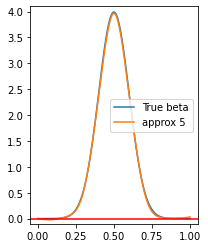

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


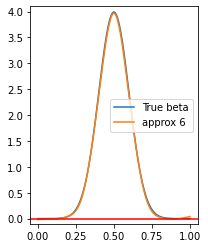

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


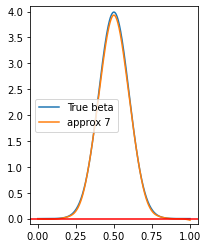

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


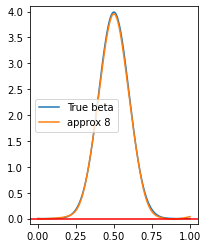

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


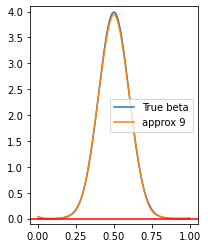

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


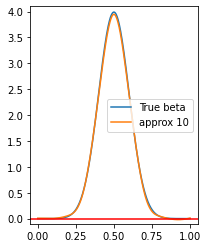

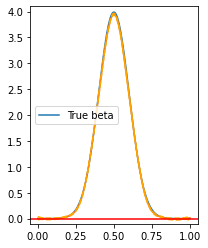

In [6]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 10

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

for N in [125]:
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_normnn001', str(i+1), str(N)])
        tttt="_".join(['y_normnn001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        plt.figure(figsize=(3,4))
        plt.plot(T2, betaT2, label = 'True beta')
        plt.plot(T2,betagorro, label=f'approx {i+1}')
        plt.axhline(0, color='red')
        plt.ylim([-0.1, 4.1])
        plt.legend()
        plt.show()
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))

mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([-0.1, 4.1])
plt.legend()
plt.show()

### Cálculo del IMSE y del MSE

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


IMSE for N= 35 2.319008084302169
MSE for N= 35 1.0404341345084072
Standard deviation of the IMSE: 0.00014640733299775557
Standard deviation of the MSE: 0.00011651235770991678
0.00014640733299775557
IMSE for N= 75 1.2939019882638951
MSE for N= 75 1.1033774790237705
Standard deviation of the IMSE: 3.325535217224645e-05
Standard deviation of the MSE: 7.777959668055717e-05
3.325535217224645e-05
IMSE for N= 125 1.094533895825904
MSE for N= 125 1.1942874305475317
Standard deviation of the IMSE: 1.8572315621271863e-05
Standard deviation of the MSE: 5.957984064277254e-05
1.8572315621271863e-05


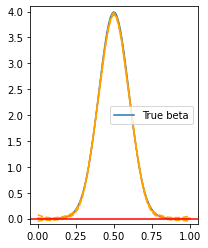

Times [153.70384049 244.1476357  367.63470054]


In [5]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE=np.zeros(n_sims)
MSE=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_normnn001', str(i+1), str(N)])
        tttt="_".join(['y_normnn001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=',N,  IMSE.sum()/n_sims*1000)
    print('MSE for N=',N,  MSE.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE))
    print('Standard deviation of the MSE:', sem(MSE))
    print(sem(IMSE))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([-0.1, 4.1])
plt.legend()
plt.show()
print('Times', time_unconstrained)

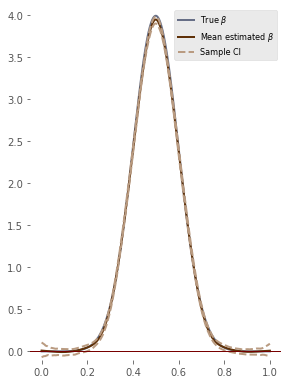

In [12]:
plt.figure(figsize=(4.5,6.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86', linewidth=2)
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108', linewidth=2)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI', linewidth=2)
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81', linewidth=2)
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=1)
plt.ylim([-0.1, 4.1])
plt.legend(loc='upper right', fontsize="8")
plt.style.use('ggplot')
plt.box(False)
plt.savefig('normal_nonneg_unconstrained_001.png', transparent=True)
plt.show()

## ERROR SIGUE UNA $N(0, 0.05)$

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


IMSE for N= 35 7.25881749595931
MSE for N= 35 2.6236115411479504
Standard deviation of the IMSE: 0.0002855997621936981
Standard deviation of the MSE: 0.00012426556573715675
IMSE for N= 75 3.2149433919543124
MSE for N= 75 3.164223120137881
Standard deviation of the IMSE: 0.00010977162587077573
Standard deviation of the MSE: 8.557819630585348e-05
IMSE for N= 125 2.0949119268751906
MSE for N= 125 3.3084836709213707
Standard deviation of the IMSE: 4.556338813592288e-05
Standard deviation of the MSE: 6.650293079955722e-05


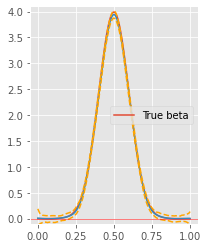

Times [160.1309638  217.56649375 250.34071732]


In [12]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_uncons=np.zeros(n_sims)
MSE_uncons=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_normnn005', str(i+1), str(N)])
        tttt="_".join(['y_normnn005', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        # plt.figure(figsize=(3,4))
        # plt.plot(T2, betaT2, label = 'True beta')
        # plt.plot(T2,betagorro, label=f'approx {i+1}')
        # plt.axhline(0, color='red')
        # plt.ylim([-0.1, 4.1])
        # plt.legend()
        # plt.show()
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_uncons[i] = (W @ (betaT2-betagorro)**2).sum()
        MSE_uncons[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE_uncons.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE_uncons.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_uncons))
    print('Standard deviation of the MSE:', sem(MSE_uncons))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth= 0.5)
plt.ylim([-0.1, 4.1])
plt.legend()
plt.show()
print('Times', time_unconstrained)

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


IMSE for N= 125 2.081312022287473
MSE for N= 125 3.446659477780717
Standard deviation of the IMSE: 4.8982198677387496e-05
Standard deviation of the MSE: 6.816214164172392e-05


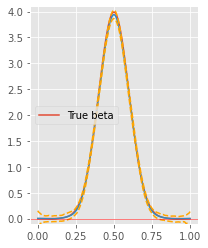

Times [256.32026148   0.           0.        ]


In [13]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_uncons=np.zeros(n_sims)
MSE_uncons=np.zeros(n_sims)

cont=0
for N in [35,75,125]:
    start_time = time.time()
    for i in range(n_sims):
        ssss="_".join(['X_normnn005', str(i+1), str(N)])
        tttt="_".join(['y_normnn005', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        # plt.figure(figsize=(3,4))
        # plt.plot(T2, betaT2, label = 'True beta')
        # plt.plot(T2,betagorro, label=f'approx {i+1}')
        # plt.axhline(0, color='red')
        # plt.ylim([-0.1, 4.1])
        # plt.legend()
        # plt.show()
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_uncons[i] = (W @ (betaT2-betagorro)**2).sum()
        MSE_uncons[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE_uncons.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE_uncons.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_uncons))
    print('Standard deviation of the MSE:', sem(MSE_uncons))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth= 0.5)
plt.ylim([-0.1, 4.1])
plt.legend()
plt.show()
print('Times', time_unconstrained)

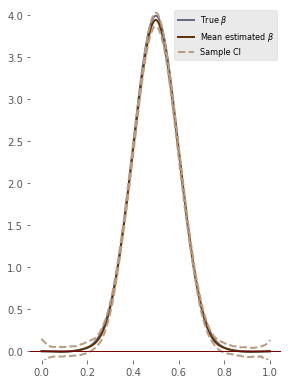

In [16]:
plt.figure(figsize=(4.5,6.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86', linewidth=2)
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108', linewidth=2)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI', linewidth=2)
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81', linewidth=2)
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=1)
plt.ylim([-0.1, 4.1])
plt.legend(loc='upper right', fontsize="8")
plt.style.use('ggplot')
plt.box(False)
plt.savefig('normal_nonneg_unconstrained_005.png', transparent=True)
plt.show()

## CONSTRAINED: ERROR SIGUE UNA $N(0, 0.01)$

### Plots

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


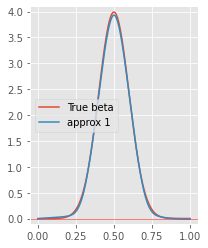

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


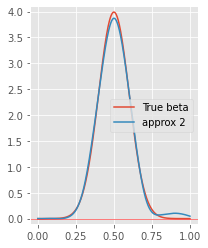

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


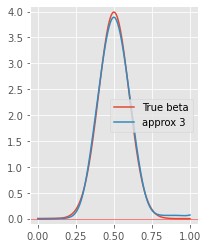

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


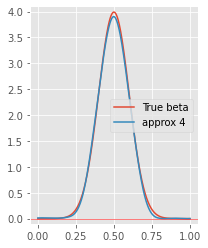

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


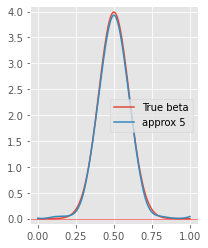

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


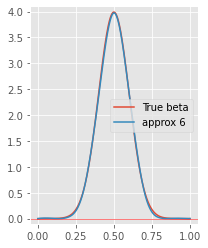

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


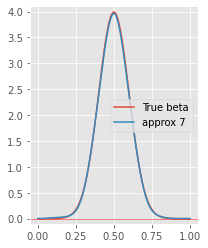

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


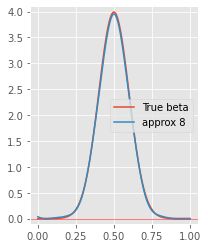

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


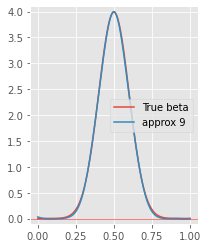

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


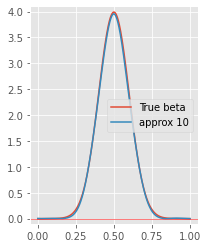

IMSE for N= 35 1.727269460129659
MSE for N= 35 0.9751794415923289
Standard deviation of the IMSE: 0.0003236608426685077
Standard deviation of the MSE: 0.0005274410990539168


c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


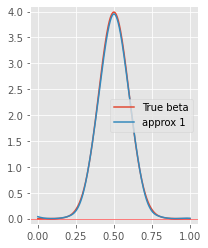

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


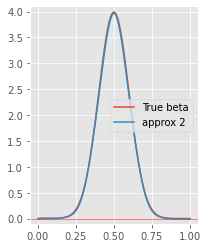

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


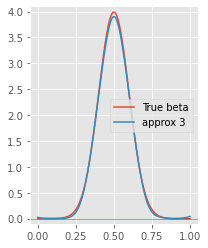

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


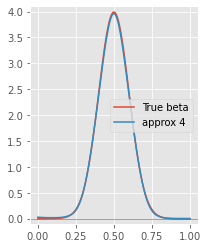

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


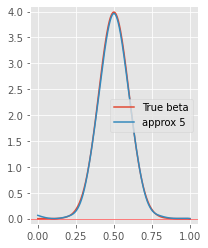

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


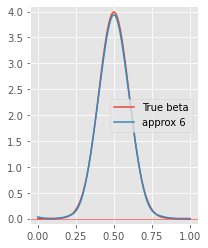

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


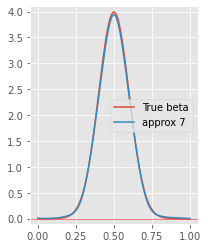

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


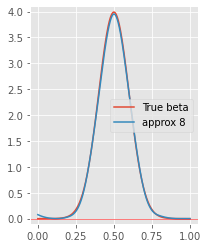

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


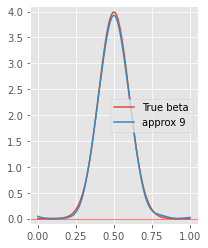

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


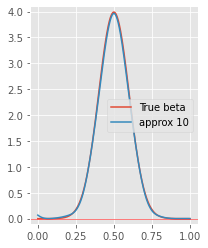

IMSE for N= 75 1.1946879392175904
MSE for N= 75 0.8056682918756926
Standard deviation of the IMSE: 9.529590611717737e-05
Standard deviation of the MSE: 0.00025929948842947454


c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


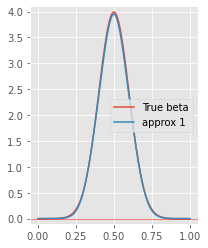

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


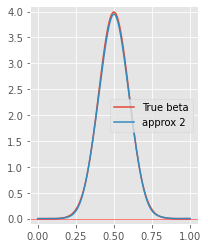

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


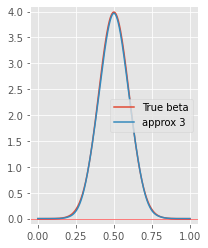

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


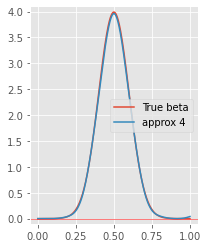

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


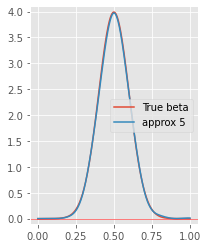

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


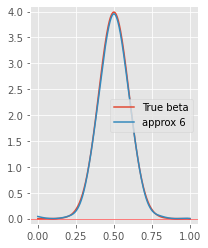

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


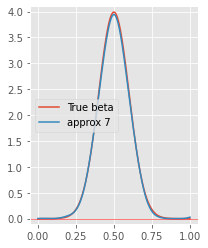

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


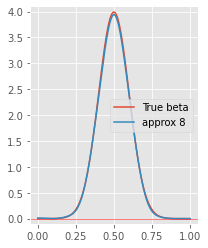

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


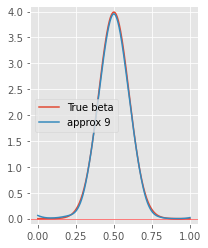

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


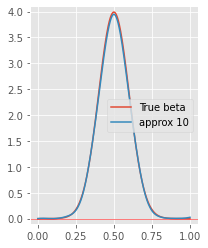

IMSE for N= 125 1.0922048210075117
MSE for N= 125 0.8164549704204737
Standard deviation of the IMSE: 6.433456800576644e-05
Standard deviation of the MSE: 0.0001471809123188852


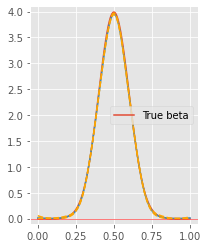

Times [ 6.43362379  9.13909578 12.85874557]


In [11]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 10

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE=np.zeros(n_sims)
MSE=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
        ssss="_".join(['X_normnn001', str(i+1), str(N)])
        tttt="_".join(['y_normnn001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=0, sign='+', sign_threshold=0.0,  plot=False)
        plt.figure(figsize=(3,4))
        plt.plot(T2, betaT2, label = 'True beta')
        plt.plot(T2,betagorro, label=f'approx {i+1}')
        plt.axhline(0, color='red', linewidth=0.5)
        plt.ylim([-0.1, 4.1])
        plt.legend()
        plt.show()
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE))
    print('Standard deviation of the MSE:', sem(MSE))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([-0.1, 4.1])
plt.legend()
plt.show()
print('Times', time_unconstrained)

### Cálculo del IMSE y del MSE

In [ ]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE=np.zeros(n_sims)
MSE=np.zeros(n_sims)

cont=0
for N in [35,75,125]:
    start_time = time.time()
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_normnn001', str(i+1), str(N)])
        tttt="_".join(['y_normnn001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=0, sign='+', sign_threshold=0.0,  plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE))
    print('Standard deviation of the MSE:', sem(MSE))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([-0.1, 4.1])
plt.legend()
plt.show()
print('Times', time_unconstrained)

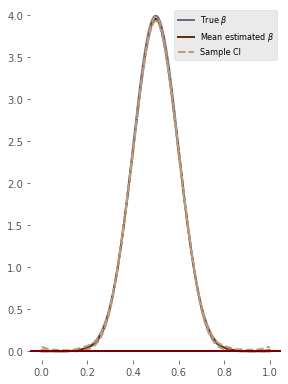

In [10]:
plt.figure(figsize=(4.5,6.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86', linewidth=2)
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108', linewidth=2)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI', linewidth=2)
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81', linewidth=2)
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=2)
plt.ylim([-0.1, 4.1])
plt.legend(loc='upper right', fontsize="8")
plt.style.use('ggplot')
plt.box(False)
plt.savefig('normal_nonneg_constrained_001.png', transparent=True)
plt.show()

### CONSTRAINED: ERROR SIGUE UNA $N(0, 0.05)$

#### Plots

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


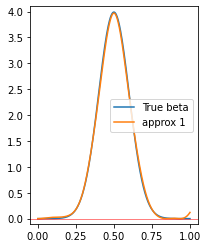

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


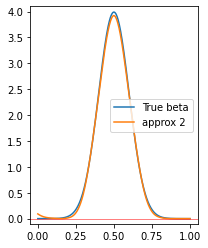

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


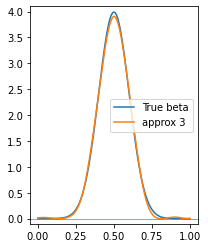

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


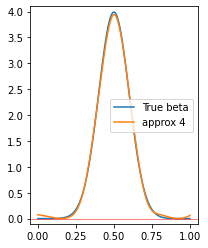

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


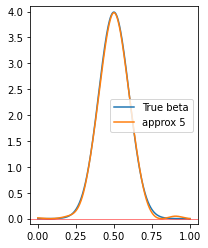

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


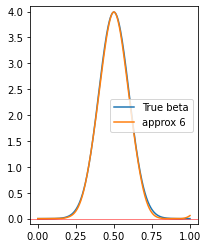

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


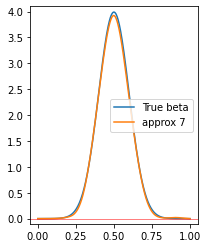

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


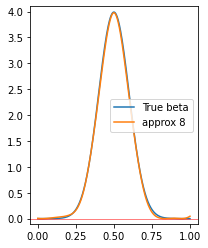

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


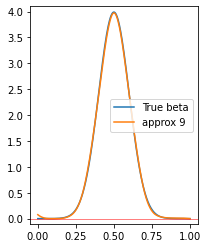

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


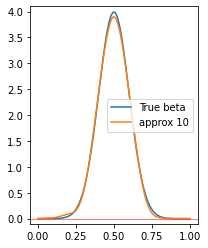

IMSE for N= 125 1.4421556697683073
MSE for N= 125 3.340662156880797
Standard deviation of the IMSE: 0.00014343109119855822
Standard deviation of the MSE: 0.00043332353929778465


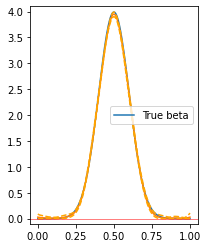

Times [18.57276726  0.          0.        ]


In [ ]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 10

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE=np.zeros(n_sims)
MSE=np.zeros(n_sims)

cont=0
for N in [125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_normnn005', str(i+1), str(N)])
        tttt="_".join(['y_normnn005', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=0, sign='+', sign_threshold=0.0,  plot=False)
        plt.figure(figsize=(3,4))
        plt.plot(T2, betaT2, label = 'True beta')
        plt.plot(T2,betagorro, label=f'approx {i+1}')
        plt.axhline(0, color='red', linewidth=0.5)
        plt.ylim([-0.1, 4.1])
        plt.legend()
        plt.show()
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE))
    print('Standard deviation of the MSE:', sem(MSE))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([-0.1, 4.1])
plt.legend()
plt.show()
print('Times', time_unconstrained)

In [ ]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_cons=np.zeros(n_sims)
MSE_cons=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_normnn005', str(i+1), str(N)])
        tttt="_".join(['y_normnn005', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=0, sign='+', sign_threshold=0.0,  plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_cons[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_cons[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE_cons.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE_cons.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_cons))
    print('Standard deviation of the MSE:', sem(MSE_cons))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([-0.1, 4.1])
plt.legend(loc='upper left')
plt.show()
print('Times', time_unconstrained)

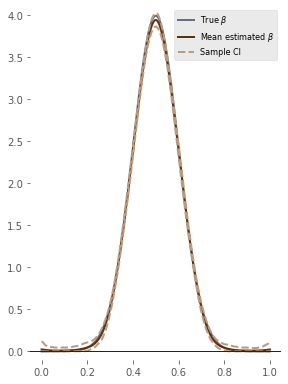

In [22]:
plt.figure(figsize=(4.5,6.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86', linewidth=2)
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108', linewidth=2)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI', linewidth=2)
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81', linewidth=2)
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=1)
plt.ylim([-0.1, 4.1])
plt.legend(loc='upper right', fontsize="8")
plt.style.use('ggplot')
plt.box(False)
plt.savefig('normal_nonneg_constrained_005.png', transparent=True)
plt.show()